# Predicting Daily PM2.5

In [102]:

import sys
import os
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from xgboost import plot_importance
from matplotlib.patches import Patch
root_dir = Path().absolute()

In [111]:
today = datetime.datetime.now() - datetime.timedelta(20)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 10, 26, 23, 2, 51, 191092)

In [7]:
project = hopsworks.login(project='akeelaf')
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

2025-11-15 21:40:18,757 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-15 21:40:18,759 INFO: Initializing external client
2025-11-15 21:40:18,759 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 21:40:19,357 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 21:40:20,273 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1277076


In [40]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=2,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-15 22:20:20,215 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/10729526 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/66133 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/48233 elapsed<00:00 remaining<?

In [41]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.280892E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [112]:
REGION = "west"
pm25_daily_fg = fs.get_feature_group(
        name="pm25_daily",
        version=3
)
wind_direction_daily_fg = fs.get_feature_group(
        name="wind_direction_daily",
        version=3
)

wind_speed_daily_fg = fs.get_feature_group(
    name="wind_speed_daily",
    version=3
)

air_temperature_daily_fg = fs.get_feature_group(
    name="air_temperature_daily",
    version=3
)

print("pm25_daily_fg:", "Loaded" if pm25_daily_fg is not None else "Not Loaded")
print("wind_direction_daily_fg:", "Loaded" if wind_direction_daily_fg is not None else "Not Loaded")
print("wind_speed_daily_fg:", "Loaded" if wind_speed_daily_fg is not None else "Not Loaded")
print("air_temperature_daily_fg:", "Loaded" if air_temperature_daily_fg is not None else "Not Loaded")

base_query = pm25_daily_fg.select_all().filter(pm25_daily_fg.timestamp >= today).filter(pm25_daily_fg.region == REGION)
joined_query = (
    base_query
        .join(
            wind_direction_daily_fg.select_all(),
            on=["timestamp", "region"]
        )
        .join(
            wind_speed_daily_fg.select_all(),
            on=["timestamp", "region"]
        )
        .join(
            air_temperature_daily_fg.select_all(),
            on=["timestamp", "region"]
        )
)
batch_data = joined_query.read()
batch_data

pm25_daily_fg: Loaded
wind_direction_daily_fg: Loaded
wind_speed_daily_fg: Loaded
air_temperature_daily_fg: Loaded
2025-11-15 23:03:03,174 WARNING: Ambiguous features detected during query construction.The feature `region` is present in feature groups ['air_temperature_daily version 3', 'pm25_daily version 3', 'wind_direction_daily version 3', 'wind_speed_daily version 3']. The feature `timestamp` is present in feature groups ['air_temperature_daily version 3', 'pm25_daily version 3', 'wind_direction_daily version 3', 'wind_speed_daily version 3']. The feature `day_of_week` is present in feature groups ['air_temperature_daily version 3', 'pm25_daily version 3', 'wind_direction_daily version 3', 'wind_speed_daily version 3']. The feature `day_of_month` is present in feature groups ['air_temperature_daily version 3', 'pm25_daily version 3', 'wind_direction_daily version 3', 'wind_speed_daily version 3']. The feature `month` is present in feature groups ['air_temperature_daily version 3',

,region,timestamp,pm25,day_of_week,day_of_month,month,year,is_weekend,pm25_lag_1d,pm25_lag_2d,...,air_temperature_daily_air_temperature_rolling_min_7d,air_temperature_daily_air_temperature_rolling_max_7d,air_temperature_daily_air_temperature_rolling_mean_14d,air_temperature_daily_air_temperature_rolling_std_14d,air_temperature_daily_air_temperature_rolling_min_14d,air_temperature_daily_air_temperature_rolling_max_14d,air_temperature_daily_air_temperature_rolling_mean_28d,air_temperature_daily_air_temperature_rolling_std_28d,air_temperature_daily_air_temperature_rolling_min_28d,air_temperature_daily_air_temperature_rolling_max_28d
0,west,2025-11-06 00:00:00+00:00,63.0,3,6,11,2025,False,55.0,62.0,...,28.490347,30.660556,29.538481,0.664545,28.490347,30.660556,29.050169,0.772779,27.615972,30.660556
1,west,2025-11-04 00:00:00+00:00,62.0,1,4,11,2025,False,44.0,55.0,...,28.490347,30.660556,29.368685,0.857281,27.615972,30.660556,29.007785,0.781703,27.615972,30.660556
2,west,2025-10-30 00:00:00+00:00,59.0,3,30,10,2025,False,55.0,64.0,...,28.867639,30.047778,28.972971,0.668787,27.615972,30.047778,28.753601,0.656951,27.615972,30.047778
3,west,2025-10-28 00:00:00+00:00,64.0,1,28,10,2025,False,51.0,39.0,...,27.615972,30.047778,28.777608,0.582630,27.615972,30.047778,28.679526,0.571557,27.615972,30.047778
4,west,2025-11-03 00:00:00+00:00,44.0,0,3,11,2025,False,55.0,58.0,...,29.185335,30.660556,29.403536,0.828254,27.615972,30.660556,28.996389,0.791787,27.615972,30.660556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,west,2025-11-02 00:00:00+00:00,55.0,6,2,11,2025,True,58.0,72.0,...,28.818333,30.382014,29.276677,0.852017,27.612986,30.382014,28.916978,0.800446,27.276667,30.382014
476,west,2025-10-29 00:00:00+00:00,55.0,2,29,10,2025,False,64.0,51.0,...,27.612986,30.343958,28.966407,0.680710,27.612986,30.343958,28.671419,0.682946,27.276667,30.343958
477,west,2025-11-01 00:00:00+00:00,58.0,5,1,11,2025,True,72.0,59.0,...,28.514969,30.382014,29.199288,0.838081,27.612986,30.382014,28.871724,0.777057,27.276667,30.382014
478,west,2025-11-05 00:00:00+00:00,55.0,2,5,11,2025,False,62.0,44.0,...,28.452134,30.382014,29.292899,0.847406,27.612986,30.382014,28.957574,0.766593,27.276667,30.382014


In [113]:
booster = retrieved_xgboost_model.get_booster()
model_features = booster.feature_names
print(len(model_features))
print(model_features[:20])

138
['pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d', 'pm25_lag_7d', 'pm25_lag_14d', 'pm25_rolling_mean_3d', 'pm25_rolling_mean_7d', 'pm25_rolling_mean_14d', 'pm25_rolling_mean_28d', 'pm25_rolling_min_3d', 'pm25_rolling_min_7d', 'pm25_rolling_min_14d', 'pm25_rolling_min_28d', 'pm25_rolling_max_3d', 'pm25_rolling_max_7d', 'pm25_rolling_max_14d', 'pm25_rolling_max_28d', 'wind_direction_daily_wind_direction_avg_mean', 'wind_direction_daily_wind_direction_avg_max', 'wind_direction_daily_wind_direction_avg_min']


In [114]:
data_features = list(batch_data.columns)

missing = set(model_features) - set(data_features)
extra   = set(data_features) - set(model_features)

print("MISSING (expected by model, not in batch_data):")
print(sorted(missing))

print("\nEXTRA (in batch_data, not used by model):")
print(sorted(extra))


MISSING (expected by model, not in batch_data):
[]

EXTRA (in batch_data, not used by model):
['air_temperature_daily_is_weekend', 'air_temperature_daily_station_name', 'day_of_month', 'day_of_week', 'is_weekend', 'month', 'pm25', 'pm25_lag_28d', 'pm25_lag_4d', 'pm25_lag_5d', 'pm25_lag_6d', 'pm25_rolling_std_14d', 'pm25_rolling_std_28d', 'pm25_rolling_std_3d', 'pm25_rolling_std_7d', 'region', 'timestamp', 'wind_direction_daily_is_weekend', 'wind_direction_daily_station_name', 'wind_speed_daily_is_weekend', 'wind_speed_daily_station_name', 'year']


In [115]:
booster = retrieved_xgboost_model.get_booster()
model_features = booster.feature_names  # this is the exact training order

# (You’ve already checked that set(model_features) == set(batch_data.columns))

# 1) Make sure we don't have any weird non-numeric types
prediction_data = batch_data[model_features].astype(float)

In [116]:
# batch_data = batch_data.drop(columns = ['station_name', 'region', 'timestamp', 'wind_speed_daily_station_name', 'air_temperature_daily_station_name', 'station_name', 'direction_std_rolling_mean_28d', 'wind_v_rolling_mean_14d', 'wind_v_lag_1d', 'wind_u_lag_3d', 'latitude', 'wind_direction_lag_7d', 'wind_u_lag_5d', 'direction_std_rolling_mean_14d', 'wind_u_rolling_mean_14d', 'day_of_month', 'is_weekend', 'longitude', 'wind_direction_avg_min', 'wind_u_lag_6d', 'wind_direction_lag_1d', 'year', 'air_temperature_daily_is_weekend', 'month', 'wind_direction_lag_14d', 'wind_direction_lag_2d', 'wind_u', 'wind_v_lag_6d', 'wind_v_lag_7d', 'wind_u_rolling_mean_3d', 'wind_direction_avg_std', 'wind_direction_lag_4d', 'wind_u_lag_1d', 'wind_u_lag_2d', 'wind_v_lag_28d', 'wind_direction_lag_5d', 'wind_v_rolling_mean_7d', 'wind_u_lag_14d', 'wind_v_rolling_mean_3d', 'wind_direction_avg_max', 'wind_v_lag_14d', 'wind_v_lag_5d', 'wind_direction_lag_28d', 'direction_std_rolling_mean_3d', 'wind_v_lag_3d', 'wind_v', 'wind_u_lag_28d', 'wind_direction_avg_mean', 'direction_std_rolling_mean_7d', 'day_of_week', 'wind_speed_daily_is_weekend', 'wind_v_lag_4d', 'wind_direction_lag_3d', 'wind_v_lag_2d', 'wind_u_lag_7d', 'wind_v_rolling_mean_28d', 'wind_u_lag_4d', 'wind_u_rolling_mean_28d', 'wind_u_rolling_mean_7d', 'wind_direction_lag_6d', 'pm25, pm25_rolling_std_3d, air_temperature_daily_is_weekend, pm25_lag_4d, day_of_month, pm25_rolling_std_7d, is_weekend, pm25_rolling_std_28d, day_of_week, pm25_lag_28d, wind_direction_daily_is_weekend, year, month, wind_speed_daily_is_weekend, pm25_lag_6d, pm25_lag_5d, pm25_rolling_std_14d'])
# batch_data = batch_data.drop(columns = ['region', 'timestamp', 'wind_speed_daily_station_name', 'air_temperature_daily_station_name', 'wind_direction_daily_station_name', 'wind_direction_daily_is_weekend', 'wind_speed_daily_is_weekend', 'air_temperature_daily_is_weekend'])
# batch_data = batch_data.drop(columns = ['pm25', 'pm25_rolling_std_3d', 'pm25_lag_4d', 'day_of_month', 'pm25_rolling_std_7d', 'is_weekend', 'pm25_rolling_std_28d', 'day_of_week', 'pm25_lag_28d', 'year', 'month', 'pm25_lag_6d', 'pm25_lag_5d', 'pm25_rolling_std_14d'])
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(prediction_data)
batch_data

,region,timestamp,pm25,day_of_week,day_of_month,month,year,is_weekend,pm25_lag_1d,pm25_lag_2d,...,air_temperature_daily_air_temperature_rolling_max_7d,air_temperature_daily_air_temperature_rolling_mean_14d,air_temperature_daily_air_temperature_rolling_std_14d,air_temperature_daily_air_temperature_rolling_min_14d,air_temperature_daily_air_temperature_rolling_max_14d,air_temperature_daily_air_temperature_rolling_mean_28d,air_temperature_daily_air_temperature_rolling_std_28d,air_temperature_daily_air_temperature_rolling_min_28d,air_temperature_daily_air_temperature_rolling_max_28d,predicted_pm25
0,west,2025-11-06 00:00:00+00:00,63.0,3,6,11,2025,False,55.0,62.0,...,30.660556,29.538481,0.664545,28.490347,30.660556,29.050169,0.772779,27.615972,30.660556,47.569187
1,west,2025-11-04 00:00:00+00:00,62.0,1,4,11,2025,False,44.0,55.0,...,30.660556,29.368685,0.857281,27.615972,30.660556,29.007785,0.781703,27.615972,30.660556,46.486927
2,west,2025-10-30 00:00:00+00:00,59.0,3,30,10,2025,False,55.0,64.0,...,30.047778,28.972971,0.668787,27.615972,30.047778,28.753601,0.656951,27.615972,30.047778,46.657070
3,west,2025-10-28 00:00:00+00:00,64.0,1,28,10,2025,False,51.0,39.0,...,30.047778,28.777608,0.582630,27.615972,30.047778,28.679526,0.571557,27.615972,30.047778,53.183834
4,west,2025-11-03 00:00:00+00:00,44.0,0,3,11,2025,False,55.0,58.0,...,30.660556,29.403536,0.828254,27.615972,30.660556,28.996389,0.791787,27.615972,30.660556,47.561310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,west,2025-11-02 00:00:00+00:00,55.0,6,2,11,2025,True,58.0,72.0,...,30.382014,29.276677,0.852017,27.612986,30.382014,28.916978,0.800446,27.276667,30.382014,47.103195
476,west,2025-10-29 00:00:00+00:00,55.0,2,29,10,2025,False,64.0,51.0,...,30.343958,28.966407,0.680710,27.612986,30.343958,28.671419,0.682946,27.276667,30.343958,55.490993
477,west,2025-11-01 00:00:00+00:00,58.0,5,1,11,2025,True,72.0,59.0,...,30.382014,29.199288,0.838081,27.612986,30.382014,28.871724,0.777057,27.276667,30.382014,52.813927
478,west,2025-11-05 00:00:00+00:00,55.0,2,5,11,2025,False,62.0,44.0,...,30.382014,29.292899,0.847406,27.612986,30.382014,28.957574,0.766593,27.276667,30.382014,53.630299


In [117]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Columns: 161 entries, region to predicted_pm25
dtypes: bool(4), datetime64[us, Etc/UTC](1), float32(1), float64(135), int32(16), object(4)
memory usage: 558.9+ KB


In [118]:
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['timestamp'])
batch_data

,region,timestamp,pm25,day_of_week,day_of_month,month,year,is_weekend,pm25_lag_1d,pm25_lag_2d,...,air_temperature_daily_air_temperature_rolling_mean_14d,air_temperature_daily_air_temperature_rolling_std_14d,air_temperature_daily_air_temperature_rolling_min_14d,air_temperature_daily_air_temperature_rolling_max_14d,air_temperature_daily_air_temperature_rolling_mean_28d,air_temperature_daily_air_temperature_rolling_std_28d,air_temperature_daily_air_temperature_rolling_min_28d,air_temperature_daily_air_temperature_rolling_max_28d,predicted_pm25,days_before_forecast_day
352,west,2025-10-28 00:00:00+00:00,64.0,1,28,10,2025,False,51.0,39.0,...,28.849604,0.569873,27.612986,30.343958,28.629375,0.613136,27.276667,30.343958,51.357296,353
283,west,2025-10-28 00:00:00+00:00,64.0,1,28,10,2025,False,51.0,39.0,...,27.929216,0.597709,26.431319,29.422986,27.859769,0.652744,26.431319,29.422986,56.895973,284
32,west,2025-10-28 00:00:00+00:00,64.0,1,28,10,2025,False,51.0,39.0,...,28.777608,0.582630,27.615972,30.047778,28.679526,0.571557,27.615972,30.047778,50.365101,33
112,west,2025-10-28 00:00:00+00:00,64.0,1,28,10,2025,False,51.0,39.0,...,28.777608,0.582630,27.615972,30.047778,28.679526,0.571557,27.615972,30.047778,49.694164,113
146,west,2025-10-28 00:00:00+00:00,64.0,1,28,10,2025,False,51.0,39.0,...,28.777608,0.582630,27.615972,30.047778,28.679526,0.571557,27.615972,30.047778,52.547787,147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,west,2025-11-06 00:00:00+00:00,63.0,3,6,11,2025,False,55.0,62.0,...,29.448861,0.703080,28.452134,30.382014,29.001320,0.778605,27.276667,30.382014,44.757355,335
320,west,2025-11-06 00:00:00+00:00,63.0,3,6,11,2025,False,55.0,62.0,...,29.448861,0.703080,28.452134,30.382014,29.001320,0.778605,27.276667,30.382014,49.013653,321
313,west,2025-11-06 00:00:00+00:00,63.0,3,6,11,2025,False,55.0,62.0,...,28.731587,0.926029,27.458333,30.161528,28.245558,0.900415,26.431319,30.161528,47.311371,314
63,west,2025-11-06 00:00:00+00:00,63.0,3,6,11,2025,False,55.0,62.0,...,29.538481,0.664545,28.490347,30.660556,29.050169,0.772779,27.615972,30.660556,44.595650,64


In [119]:
batch_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 352 to 0
Columns: 162 entries, region to days_before_forecast_day
dtypes: bool(4), datetime64[us, Etc/UTC](1), float32(1), float64(135), int32(16), int64(1), object(4)
memory usage: 566.2+ KB


In [120]:
def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['timestamp']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

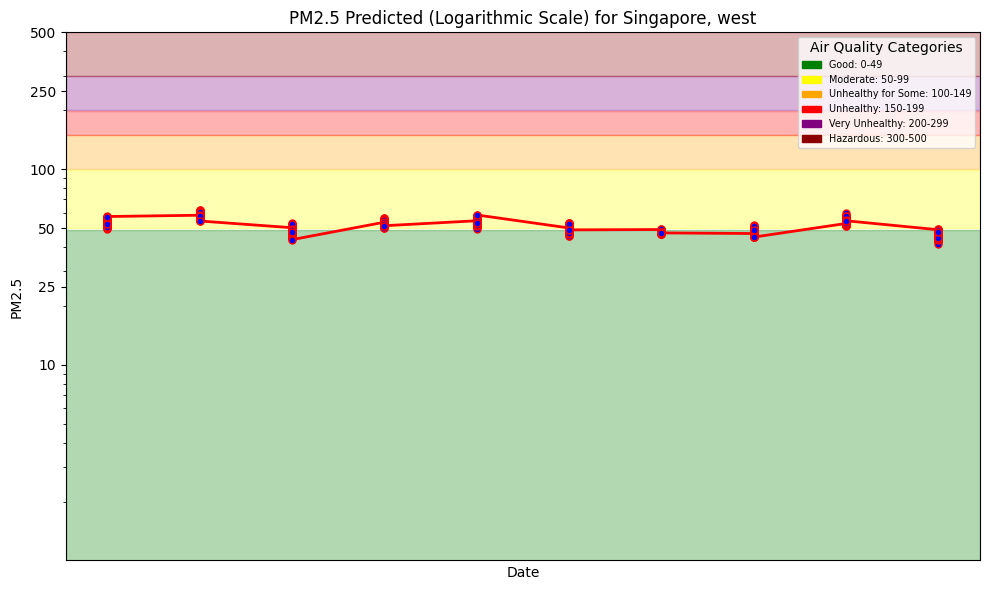

In [121]:
pred_file_path = f"{root_dir}/../air_quality_model/images/pm25_forecast.png"
plt = plot_air_quality_forecast('Singapore', REGION, batch_data, pred_file_path)
plt.show()